In [1]:
import numpy as np
import matplotlib.pyplot as plt
import legwork as lw
import astropy.units as u
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid, cumulative_trapezoid
from astropy.cosmology import Planck18, z_at_value
from scipy.integrate import trapezoid
import paths
from matplotlib import colors
import tqdm
import utils
import paths
import cmasher as cmr

In [2]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = True
fs = 12


# update various fontsizes to match
params = {'figure.figsize': (6,4),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.7 * fs,
          'ytick.labelsize': 0.7 * fs}
plt.rcParams.update(params)


# set up the LISA frequency grid
f_LISA = np.logspace(-1, -5, 150) * u.Hz

# set up the LIGO eccentricity range
e_LIGO = np.logspace(-6, np.log10(0.0005), 10)
e_LIGO = np.append(0, e_LIGO)
e_LIGO_round = np.array([f"{e:.2e}" for e in e_LIGO])


# get the mass, mass ratio, and rate grids
down_samp_fac=25
mass_1, mass_ratio, M1, Q, dN_dm1dqdVcdt = utils.get_LIGO_rate(down_samp_fac=down_samp_fac)

mass_1 = mass_1
mass_ratio = mass_ratio
MM, QQ, EE_LIGO, FF = np.meshgrid(mass_1, mass_ratio, e_LIGO, f_LISA, indexing='ij')

In [3]:
EE_LISA = np.load(paths.data / 'e_LISA.npy')
TT_LISA = np.load(paths.data / 't_merge.npy') * u.Gyr
VC = np.load(paths.data / 'comoving_volume.npy') * u.Gpc**3
DH = np.load(paths.data / 'horizon_distance.npy') * u.Gpc 

In [4]:
def get_VC_new(snr_thresh_new, DH, VC):
    snr_thresh_data = 12
    DH = DH * snr_thresh_data / snr_thresh_new
    VC = 4/3 * np.pi * DH**3

    return VC

In [5]:
dT_LIGO_df_LISA = utils.dTmerger_df(MM, QQ*MM, FF, EE_LISA).to(u.yr / u.Hz)

In [6]:
np.shape(dT_LIGO_df_LISA), np.shape(dN_dm1dqdVcdt)

((40, 20, 11, 150), (20, 40))

In [7]:
cs = cmr.take_cmap_colors('cmr.dusk', len(mass_1), cmap_range=(0.15, 0.9), return_fmt='hex')
cs2 = cmr.take_cmap_colors('cmr.eclipse', 3, cmap_range=(0.15, 0.9), return_fmt='hex')
ecc_ind = 0
q_ind = 18
ind_m_10 = 3
ind_m_35 = 14
ind_m_80 = 32

In [26]:
dn_LISA = np.zeros((len(mass_1), len(f_LISA)))
for ff, forb in enumerate(f_LISA):
    dn_LISA[:,ff] = trapezoid(mass_ratio, (dT_LIGO_df_LISA[:,:,ecc_ind,ff] * dN_dm1dqdVcdt[:, :].T)).to(1/u.Hz / u.Msun / u.Gpc**3)

dN_dm1_list = []
for snr_thresh in [1,7,12]:
    VC_new = get_VC_new(snr_thresh, DH, VC)
    dN_LISA_obs = np.zeros((len(mass_1), len(f_LISA)))
    dN_LISA_obs[:,ff] = trapezoid((dT_LIGO_df_LISA[:,:,ecc_ind,ff] * dN_dm1dqdVcdt[:, :].T * VC_new[:,:,ecc_ind,ff]), mass_ratio).to(1/u.Hz / u.Msun)
    dN_LISA_obs = dN_LISA_obs * u.s / u.Msun
    dN_dm1_list.append(trapezoid(dN_LISA_obs, -f_LISA).to(1/u.Msun))


In [27]:
dN_dm1_list

[<Quantity [0.00000000e+00, 1.63891177e-19, 9.85908827e-17, 3.78782464e-16,
            3.77724687e-16, 3.47889172e-16, 3.28366402e-16, 3.21563305e-16,
            3.33339486e-16, 3.79954631e-16, 4.97436581e-16, 7.52198380e-16,
            1.21536947e-15, 1.75825653e-15, 1.82493942e-15, 1.43254713e-15,
            9.98669350e-16, 6.78660714e-16, 4.80775788e-16, 3.69604751e-16,
            3.09869941e-16, 2.78238861e-16, 2.61539131e-16, 2.52730460e-16,
            2.48074272e-16, 2.45580468e-16, 2.44195416e-16, 2.43371907e-16,
            2.42834838e-16, 2.42429951e-16, 2.40838577e-16, 2.29310109e-16,
            2.02799794e-16, 1.70797970e-16, 1.37675928e-16, 1.09055586e-16,
            8.28220340e-17, 5.72354842e-17, 3.59823035e-17, 1.64399361e-17] 1 / solMass>,
 <Quantity [0.00000000e+00, 4.77816844e-22, 2.87436976e-19, 1.10432205e-18,
            1.10123815e-18, 1.01425415e-18, 9.57336450e-19, 9.37502348e-19,
            9.71835236e-19, 1.10773945e-18, 1.45025242e-18, 2.19299819e-18

In [21]:
dn_LISA = dn_LISA * u.s / u.Msun / u.Gpc**3


In [22]:
dn_dm1 = trapezoid(f_LISA, dn_LISA).to(1/u.Msun / u.Gpc**3)
dn_dm1[0] = 1e-19 / u.Msun / u.Gpc**3

In [23]:
labels = [r'$M_1=10\,M_{\odot}$', r'$M_1=35\,M_{\odot}$', r'$M_1=80\,M_{\odot}$']
labels_snr = [r'$SNR > 1$', r'$SNR > 7$', r'$SNR > 12$']

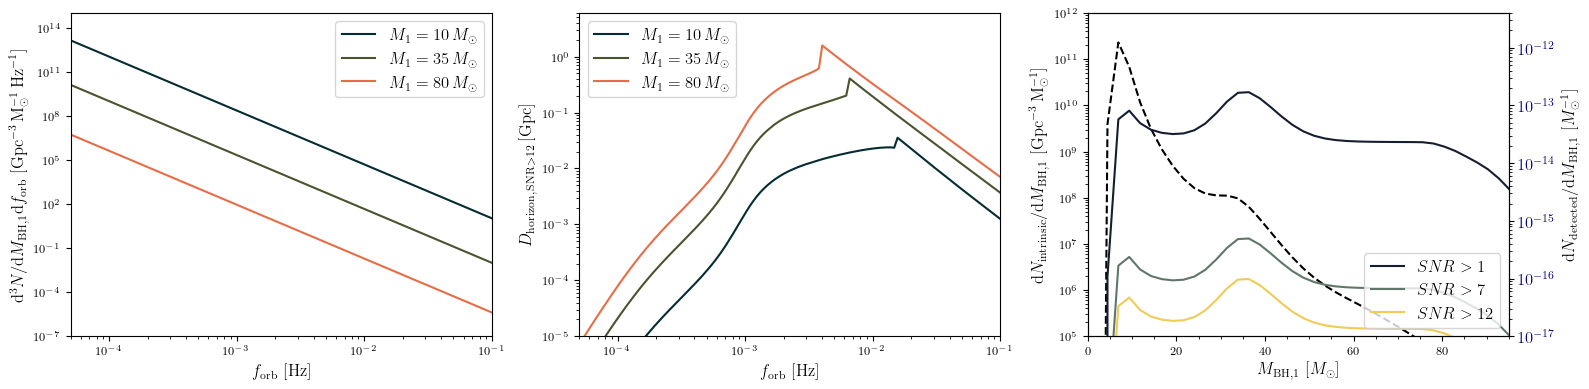

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
#p = ax1.scatter(FF[:,q_ind,ecc_ind,:], MM[:,q_ind,ecc_ind,:], c=dn_LISA.value, norm=colors.LogNorm(vmax=1e14), s=14, marker='o')
for ii, ind in enumerate([ind_m_10, ind_m_35, ind_m_80]):
    ax1.plot(FF[ind,q_ind,ecc_ind,:], dn_LISA.value[ind,:], color=cs[ind], label=labels[ii])
ax1.set_xscale('log')
#cbar = plt.colorbar(p)
#cbar.set_label(label=r'$\mathrm{d}^3N / \mathrm{d}M_{\mathrm{BH,1}} \mathrm{d}f_{\rm orb}$ [$\rm{Gpc}^{-3}\,M_{\odot}^{-1}\,\rm{Hz}^{-1}$]')

ax1.set_xlabel(r'$f_{\rm orb}$ [Hz]')
ax1.set_ylabel(r'$\mathrm{d}^3N / \mathrm{d}M_{\mathrm{BH,1}} \mathrm{d}f_{\rm orb}$ [$\rm{Gpc}^{-3}\,M_{\odot}^{-1}\,\rm{Hz}^{-1}$]')
ax1.set_yscale('log')
ax1.set_xlim(5e-5, 0.1)
ax1.set_ylim(1e-7, 1e15)
ax1.legend()
ax1.minorticks_on()

for ii, ind in enumerate([ind_m_10, ind_m_35, ind_m_80]):
    ax2.plot(f_LISA, DH[ind, q_ind, ecc_ind, :], color=cs[ind], label=labels[ii])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.set_ylabel(r'$D_{\rm{horizon,\,SNR>12}}\,[\rm{Gpc}]$')
ax2.set_xlabel(r'$f_{\rm orb}$ [Hz]')
ax2.set_ylim(1e-5, 6)
ax2.set_xlim(5e-5, 0.1)

ax3.plot(mass_1.value, dn_dm1.value, ls='--', color='black')
ax3.set_yscale('log')
ax3.set_ylim(1e5, 1e12)
ax3.minorticks_on()
ax3.set_ylabel(r'$\mathrm{d}N_{\rm{intrinsic}} / \mathrm{d}M_{\mathrm{BH,1}}$ [$\rm{Gpc}^{-3}\,M_{\odot}^{-1}$]')
ax3.set_xlabel(r'$M_{\mathrm{BH,1}}$ [$M_{\odot}$]')

ax4 = ax3.twinx()

# Plot data on the second y-axis
color = 'navy'
ax4.set_ylabel(r'$\mathrm{d}N_{\rm{detected}} / \mathrm{d}M_{\mathrm{BH,1}}$ $[M_{\odot}^{-1}$]')
for ii, dNdm1 in enumerate(dN_dm1_list):
    ax4.plot(mass_1, dNdm1, color=cs2[ii], label=labels_snr[ii])
ax4.set_ylim(1e-17, 4e-12)
ax4.set_xlim(0, 95)
ax4.set_yscale('log')
ax4.legend(loc='lower right')
ax4.tick_params(axis='y', labelcolor=color, labelsize=12)
fig.tight_layout()